In [21]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Function to apply heatmap to an image
def apply_heatmap(image_path, output_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize the image to the range 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Apply the heatmap
    heatmap = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    
    # Save the heatmap image
    cv2.imwrite(output_path, heatmap)

# Path to the folder containing raw images
input_folder = 'D:/GitProjects/Datasets/ImageData/valid/non_autistic'
# Path to the folder to save heatmap images
output_folder = 'D:/GitProjects/Datasets/data_heatmap/valid/non_autistic'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        
        apply_heatmap(input_path, output_path)

print("Heatmap images have been saved to:", output_folder)


Heatmap images have been saved to: D:/GitProjects/Datasets/data_heatmap/valid/non_autistic


In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

# Set up data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [36]:
# No data augmentation for validation data, only rescaling
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load train and validation datasets
train_generator = train_datagen.flow_from_directory(
    'D:/GitProjects/Datasets/data_heatmap/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

#validation_generator = valid_datagen.flow_from_directory(
#    'D:/GitProjects/Datasets/data_heatmap/valid',
#    target_size=IMAGE_SIZE,
#    batch_size=BATCH_SIZE,
#    class_mode='binary'
#)

Found 2536 images belonging to 2 classes.


In [37]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)  # Added dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Added another dropout layer
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers during initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback (optional but useful)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
initial_epochs = 20  # Adjust the number of initial training epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=initial_epochs,
    callbacks=[early_stopping]
)

# Unfreeze some of the top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze more layers
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model (Additional training)
fine_tune_epochs = 20  # Adjust the number of fine-tuning epochs
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=fine_tune_epochs,
    callbacks=[early_stopping]
)

# Save the model
model.save('asd_classifier_efficientnetb0.h5')

Epoch 1/20


d:\ProgramFilesD\Anaconda\envs\default_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5037 - loss: 0.7522
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4531 - loss: 0.7482
Epoch 3/20


d:\ProgramFilesD\Anaconda\envs\default_env\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4771 - loss: 0.7952
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 527us/step - accuracy: 0.4531 - loss: 0.7942
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5233 - loss: 0.7334
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5156 - loss: 0.7123 
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5035 - loss: 0.7408
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 579us/step - accuracy: 0.5156 - loss: 0.7233
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5181 - loss: 0.7280
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 553us/step - accuracy: 0.3906 - loss: 0.8679
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4961 - loss: 0.7211
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step - accuracy: 0.5625 - loss: 0.7237
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5238 - loss: 0.7091
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 347us/step - accuracy: 0.4531 - 

In [ ]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Load the trained model
model = tf.keras.models.load_model('asd_classifier_efficientnetb0.h5')

# Recompile the model to ensure metrics are built
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define image size and batch size
IMAGE_SIZE = (224, 224)

# Path to the folder containing raw test images
raw_test_folder = 'D:/GitProjects/Datasets/Datalatest/train/non_autistic'

# Function to apply heatmap to an image
def apply_heatmap(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize the image to the range 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Apply the heatmap
    heatmap = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    
    # Return the heatmap image
    return heatmap

# Function to preprocess and predict a single image
def predict_image(image_path):
    # Convert raw image to heatmap
    heatmap_img = apply_heatmap(image_path)
    
    # Resize heatmap image to model input size
    heatmap_img = cv2.resize(heatmap_img, IMAGE_SIZE)
    
    # Convert heatmap image to array and preprocess
    img_array = img_to_array(heatmap_img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]

    # Make prediction
    prediction = model.predict(img_array)
    
    # Get the class label
    class_label = 'autistic' if prediction[0] > 0.5 else 'non_autistic'
    return class_label, prediction[0]

# Process each image in the raw test folder
for filename in os.listdir(raw_test_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(raw_test_folder, filename)
        class_label, confidence = predict_image(image_path)
        print(f"Image: {filename} | Predicted: {class_label} | Confidence: {confidence[0]:.4f}")


In [8]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import io
import logging

# Ensure that TensorFlow uses the custom Swish function and FixedDropout layer
def swish(x):
    return tf.keras.backend.sigmoid(x) * x

class FixedDropout(tf.keras.layers.Dropout):
    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape
        symbolic_shape = tf.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)

class EyePredictor:
    def __init__(self, model_path, logger: logging.Logger):
        self.model_path = model_path  # Specify your model path here
        self.model = self.load_model()
        self.logger = logger

    def load_model(self):
        # Load your EfficientNet model with custom objects
        model = load_model(self.model_path, custom_objects={'swish': swish, 'FixedDropout': FixedDropout})
        return model

    def preprocess_image(self, img):
        target_size = (224, 224)  # Adjust according to your model's input size
        if isinstance(img, str):
            img = image.load_img(img, target_size=target_size)
        elif isinstance(img, io.BytesIO):
            img = image.load_img(img, target_size=target_size)
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")
        
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
        img_array /= 255.0  # Normalize to [0,1]
        return img_array

    def predict(self, img):
        self.logger.info("Starting prediction.")
        img_array = self.preprocess_image(img)
        # Make prediction
        prediction = self.model.predict(img_array)[0][0]
        # Interpret prediction
        if prediction >= 0.5:
            result = 'Autistic'
        else:
            result = 'Not Autistic'
        return result

    def predict_folder(self, folder_path):
        results = {}
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                prediction = self.predict(file_path)
                results[filename] = prediction
                self.logger.info(f"Processed {filename}: {prediction}")
            except Exception as e:
                self.logger.error(f"Error processing {filename}: {e}")
        return results


In [ ]:
import logging


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize predictor
model_path = 'autism_efficient_net20.h5'
predictor = EyePredictor(model_path, logger)

# Predict images in a folder
folder_path = 'D:/GitProjects/Datasets/ImageData/test/autistic'
results = predictor.predict_folder(folder_path)

# Print results
for filename, prediction in results.items():
    print(f"{filename}: {prediction}")


## testing

In [18]:
import os
import tensorflow as tf
import numpy as np
import io
import logging
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Swish activation function
def swish(x):
    return tf.keras.backend.sigmoid(x) * x

# Custom Dropout layer with fixed seed
class FixedDropout(tf.keras.layers.Dropout):
    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape
        symbolic_shape = tf.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)

class EyePredictor:
    def __init__(self, model_path, logger: logging.Logger):
        self.model_path = model_path  # Specify your model path here
        self.model = self.load_model()
        self.logger = logger

    def load_model(self):
        # Load your EfficientNet model with custom objects
        model = load_model(self.model_path, custom_objects={'swish': swish, 'FixedDropout': FixedDropout})
        return model

    def preprocess_image(self, img):
        target_size = (224, 224)  # Adjust according to your model's input size
        if isinstance(img, str):
            img = image.load_img(img, target_size=target_size)
        elif isinstance(img, io.BytesIO):
            img = image.load_img(img, target_size=target_size)
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")
        
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
        img_array /= 255.0  # Normalize to [0,1]
        return img_array

    def predict(self, img):
        self.logger.info("Starting prediction.")
        img_array = self.preprocess_image(img)
        # Make prediction
        prediction = self.model.predict(img_array)[0][0]
        return prediction

    def predict_folder(self, folder_path):
        results = {}
        for subfolder in ['autistic', 'non_autistic']:
            subfolder_path = os.path.join(folder_path, subfolder)
            if not os.path.exists(subfolder_path):
                self.logger.error(f"Subfolder {subfolder} does not exist in {folder_path}")
                continue
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                try:
                    prediction = self.predict(file_path)
                    results[file_path] = prediction
                    self.logger.info(f"Processed {filename} in {subfolder}: {prediction}")
                except Exception as e:
                    self.logger.error(f"Error processing {filename} in {subfolder}: {e}")
        return results

    def evaluate_model(self, validation_folder):
        y_true = []
        y_pred = []
        for subfolder in ['autistic', 'non_autistic']:
            subfolder_path = os.path.join(validation_folder, subfolder)
            if not os.path.exists(subfolder_path):
                self.logger.error(f"Subfolder {subfolder} does not exist in {validation_folder}")
                continue
            true_label = 1 if subfolder == 'autistic' else 0
            for filename in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, filename)
                y_true.append(true_label)
                prediction = self.predict(file_path)
                y_pred.append(prediction)
        
        y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
        
        accuracy = accuracy_score(y_true, y_pred_binary)
        class_report = classification_report(y_true, y_pred_binary)
        conf_matrix = confusion_matrix(y_true, y_pred_binary)

        self.logger.info(f"Accuracy: {accuracy}")
        self.logger.info(f"Classification Report: \n{class_report}")
        self.logger.info(f"Confusion Matrix: \n{conf_matrix}")

        return accuracy, class_report, conf_matrix, y_true, y_pred

    def plot_precision_recall_curve(self, y_true, y_pred):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        
        plt.figure(figsize=(10, 7))
        plt.plot(recall, precision, marker='.', label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

        return precision, recall, pr_auc

    def evaluate_and_plot(self, validation_folder):
        accuracy, class_report, conf_matrix, y_true, y_pred = self.evaluate_model(validation_folder)
        
        # Print classification report
        print(f"Classification Report: \n{class_report}")
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Autistic', 'Autistic'], yticklabels=['Not Autistic', 'Autistic'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Plot precision-recall curve
        precision, recall, pr_auc = self.plot_precision_recall_curve(y_true, y_pred)

        return accuracy, class_report, conf_matrix, precision, recall, pr_auc


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

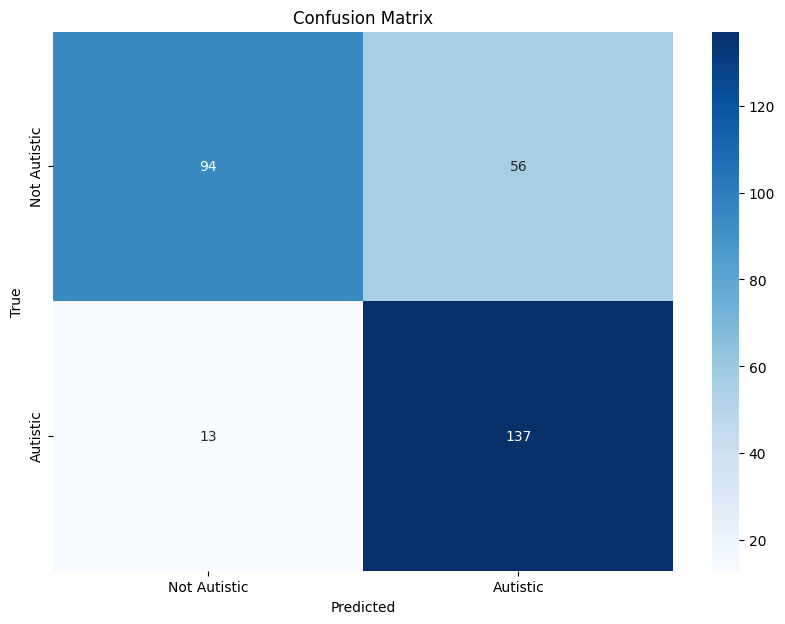

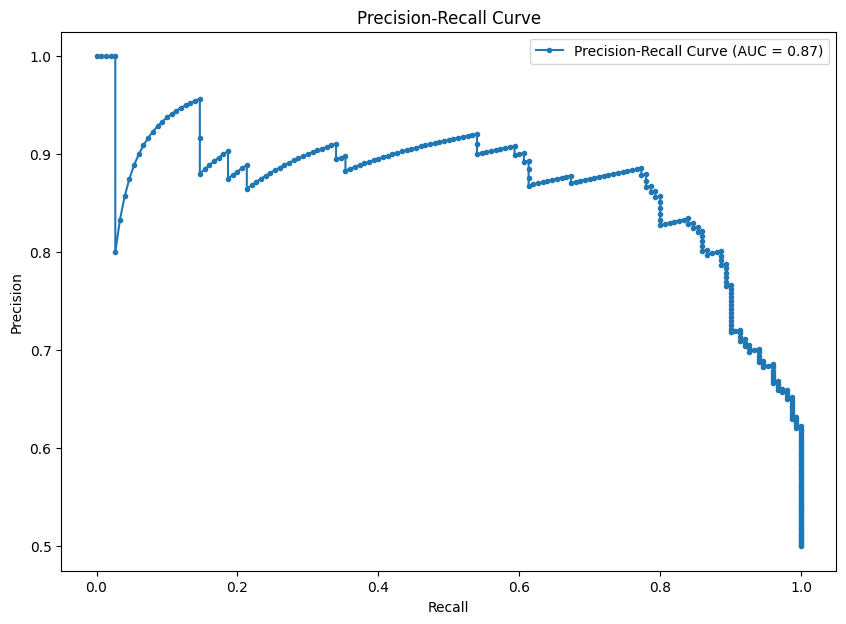

D:/GitProjects/Datasets/ImageData/train/autistic\0001.jpg: 0.8811510801315308
D:/GitProjects/Datasets/ImageData/train/autistic\0002.jpg: 0.9315729737281799
D:/GitProjects/Datasets/ImageData/train/autistic\0003.jpg: 0.4214647114276886
D:/GitProjects/Datasets/ImageData/train/autistic\0004.jpg: 0.8801001310348511
D:/GitProjects/Datasets/ImageData/train/autistic\0005.jpg: 0.9524415731430054
D:/GitProjects/Datasets/ImageData/train/autistic\0006.jpg: 0.935712456703186
D:/GitProjects/Datasets/ImageData/train/autistic\0007.jpg: 0.8630595803260803
D:/GitProjects/Datasets/ImageData/train/autistic\0008.jpg: 0.7779744863510132
D:/GitProjects/Datasets/ImageData/train/autistic\0009.jpg: 0.9995720982551575
D:/GitProjects/Datasets/ImageData/train/autistic\0010.jpg: 0.7181068658828735
D:/GitProjects/Datasets/ImageData/train/autistic\0011.jpg: 0.7746727466583252
D:/GitProjects/Datasets/ImageData/train/autistic\0012.jpg: 0.897860050201416
D:/GitProjects/Datasets/ImageData/train/autistic\0013.jpg: 0.87527

In [19]:
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize predictor
model_path = 'autism_efficient_net20.h5'
predictor = EyePredictor(model_path, logger)

# Predict images in a folder
folder_path = 'D:/GitProjects/Datasets/ImageData/train/'
results = predictor.predict_folder(folder_path)

# Evaluate model and plot metrics
validation_folder_path = 'D:/GitProjects/Datasets/ImageData/test'
accuracy, class_report, conf_matrix, precision, recall, pr_auc = predictor.evaluate_and_plot(validation_folder_path)

# Print results
for filepath, prediction in results.items():
    print(f"{filepath}: {prediction}")

print(f"Accuracy: {accuracy}")
print(f"Classification Report: \n{class_report}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Precision-Recall AUC: {pr_auc}")


In [38]:
print(f"Accuracy: {accuracy}")
print(f"Classification Report: \n{class_report}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Precision-Recall AUC: {pr_auc}")

Accuracy: 0.77
Classification Report: 

              precision    recall  f1-score   support

           0       0.88      0.63      0.73       150
           1       0.71      0.91      0.80       150

    accuracy                           0.77       300
   macro avg       0.79      0.77      0.77       300
weighted avg       0.79      0.77      0.77       300

Confusion Matrix: 
[[ 94  56]
 [ 13 137]]
Precision-Recall AUC: 0.8682445349282353
